# Optimization (tutorial)

In this tutorial you will learn to code and use common optimization algorithms for static models.


---

## Profit optimization by a monopolist

A monopolist produces quantity $q$ of goods X at price $p$. Its cost function is $c(q) = 0.5 + q (1-qe^{-q})$

The consumer's demand for price $p$ is $x(p)=2 e^{-0.5 p}$ (constant elasticity of demand to price).

__Write down the profit function of the monopolist and find the optimal production (if any). Don't use any library except for plotting.__



The profit function of the monopolist is written as: $\Pi(q) =  qP(q) - c(q)$. And let's express the price function as a function of $q$, $P(q)$ = $-2\log{(0.5q)}$

$$\begin{align*}
    \Pi(q) &= -2\log{(0.5q)}q - 0.5- q(1-qe^{-q})
\end{align*}$$

Minimizing $-\Pi(q)$ is the same as maximize $\Pi(q)$ hence we compute $-\Pi$ and its derivative and we implement a gradient descent algorithm.

In [28]:
function derivq(q::Float64)
    return 2+2*log(0.5*q)-2*q*exp(-q)+exp(-q)*q^2
end

function gd(q::Float64,ϵ = 0.001, η = 0.001,iter = 1000)
    i = 0
    d = 1
    dist = []
    while i < iter && abs(d) > ϵ
        d = derivq(q)
        q_next = q*(1-0.01)-0.01*d
        push!(dist,q_next-q)
        q = q_next
        i += 1
    end
    return q,i
end

gd (generic function with 5 methods)

In [31]:
gd(10.0)

(0.6634934453131063, 1000)

Our function gives the optimal quantity as q = 0.66, but we see that we don't get a great accuracy since the loop is always exited after the maximum number of iterations

---

## (modified) Solow model

This model tries to explain long-term productivity, its relation to productivity and the speed of convergence.

The setup is the following:

- a country accumulates capital $k_t$
- population $n_t$ grows at rate $g$ (so that $n_{t+1}=g n_t$
- capital and labour are combined to produce $y_t = A F(k_t, n_t)$ where $A>0$ is total factor productivity.
- capital depreciates at rate $\delta \in ]0,1[$. Its law of motion is $k_{t+1}=(1-\delta)k_{t}+i_{t}$ where $i_t$ is the amount invested at time $t$
- production is either consumed or invested: $y_t = c_t + i_t$

We choose a Cobb-Douglas specification with constant returns to scale $F(k_t, n_t) = k_t^{\alpha} n_t^{1-\alpha}$.

In the Ramsey–Cass–Koopmans  model (also called neoclassical growth model), a representative agent would choose $c_t$ in every period so as to maximize an intertemporal utility like $\sum_{t \geq 0} \beta^t U(c_t)$ where $\beta \in [0,1[$ is a time discount and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ is the instantaneous felicity.

Here we follow the Solow-Swan specification and assume instead there is a fixed fraction $s\in[0,1[$ of income in every period, which is saved and invested in every period. In other words investment (or savings) is given by:

$$i_t = s y_t$$

As a result, the dynamic of capital and all other variables will be backward looking and can be simulated easily.

__Calibrate parameters $\beta$, $\delta$ and $g$, that is, propose plausible values for them, from the litterature, or by matching some observable fact.__

In [43]:
β = 0.3
δ = 0.03
g = 0.05#annual of change of the french population is 0.2%, we reasonably assume that population is increasing

0.05

__Detrend the equations of the model w.r.t. population growth. Denote the detrended variables with a hat (in the code we assume all variables are detrended and ignore the hat).__

We need to express our variable of interest in per capita values. We get the following:

$\hat{F}(k_t,n_t) = k_t^{\alpha}N_t^{-\alpha} \\
\hat{y}_t = A\hat{F}(k_t,n_t) \\
\hat{k}_{t+1} = (1-\delta)\frac{k_{t}}{n_t} +\frac{i_t}{n_t} $


Our goal is to compute the steady-state and assess its stability.

__Compute a function `f` which returns the capital $\hat{k}_{t+1}$ as a function of $\hat{k_t}$. It is suggested to define `f(k::Float64, p::Dict{Symbol, Float64})` where `p` is a dictionary of parameters.__

 (note: such a dictionary can be defined as `p = Dict(:a=>0.9, :b=>4)` and accessed with brackets `p[:a]` or `p[:b]`) (note2: symbols like `:a` or `:b` are lightweight string. The content must be a valid julia identifier so that it is valid to write `a=p[:a]`)

In [49]:
s = 0.5
α = 0.3
A = 2.
p = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>α)
function f(k::Float64, p::Dict{Symbol,Float64})
    return p[:s]*A*(k^p[:a])+(1-p[:g]-p[:d])*k
end

f (generic function with 1 method)

__Starting from an initial level $\hat{k}_0$ compute successive iterates of `f` to find the long-run level $\overline{k}$ of capital per capita. (Bonus: produce a nice plot of the convergence)__

In [108]:
k0 = 2.0
function iterate(k::Float64,p::Dict{Symbol,Float64})
    cap_l = []
    for i=0:100
        cap = f(k, p)
        k = cap
        push!(cap_l,cap)
    end
    return cap_l #returns list of 100 capital levels
end

iterate (generic function with 1 method)

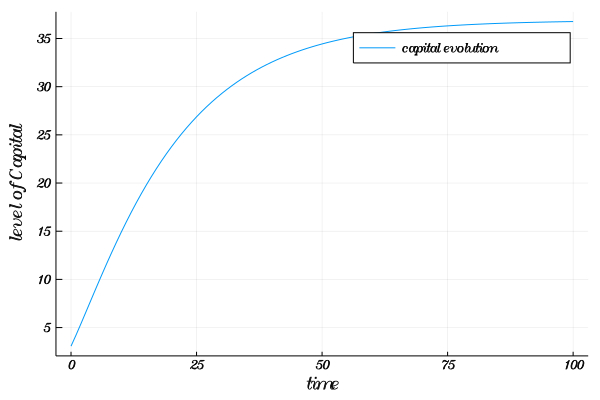

In [109]:
t = [i for i in 0:100]
using Plots
plot(t,cap_l,xlabel = "time",ylabel = "level of Capital",label = "capital evolution")

__What factors affect the steady-state level of capital?__

The steady state level of capital increases in $A$, in $s$ and in $\alpha$ and decreases in $\delta$ and $g$

__Study the stability of $f$ around $\overline{k}$. Which factors affect the speed of convergence towards the steady-state?__

In [110]:
#We look for the lambda corresponding to our stable point

x_100 = cap_l[100]
x_99 = cap_l[99]
x_98 = cap_l[98]

lambda_lr = abs(x_100-x_99)/abs(x_99-x_98)

#error 
a = abs(x_98 - x_100) 
b = 1/(1-lambda_lr)*abs(x_99-x_100)
a<b
(1/lambda_lr)

1.0592393563136393

We have derived the error bound

We know that the convergence speed is 1/lambda_lr. Thus let's plot the convergence speed with respect to the parameters $\alpha$, $\delta$ to see how it is affected

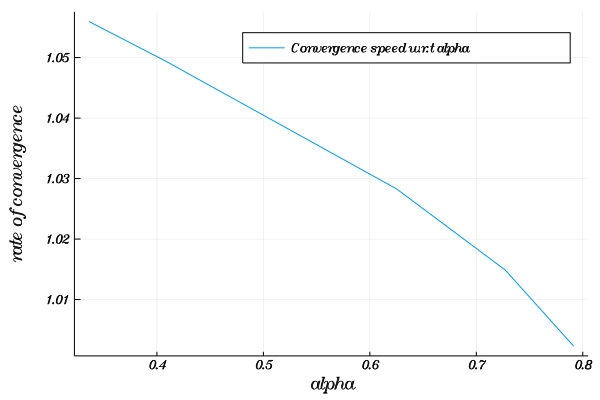

In [129]:
k0 = 2.0
alph_l = rand(Float64,(5))
sort!(alph_l)
function convergence(k::Float64,p::Dict{Symbol,Float64})
    l1 = iterate(k,p)
    x_100 = l1[100] #depends on the number of iterations in iterate
    x_99 = l1[99]
    x_98 = l1[98]
    lambda_lr = abs(x_100-x_99)/abs(x_99-x_98)
    return (1/lambda_lr)
end
d1 = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>alph_l[1])
d2 = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>alph_l[2])
d3 = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>alph_l[3])
d4 = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>alph_l[4])
d5 = Dict(:b=>β,:d=>δ,:g=>g,:s=>s,:a=>alph_l[5])


conv_alph = [convergence(k0,d1),convergence(k0,d2),convergence(k0,d3),convergence(k0,d4),convergence(k0,d5)]

plot(alph_l,conv_alph,xlabel="alpha",ylabel="rate of convergence",label="Convergence speed w.r.t alpha")

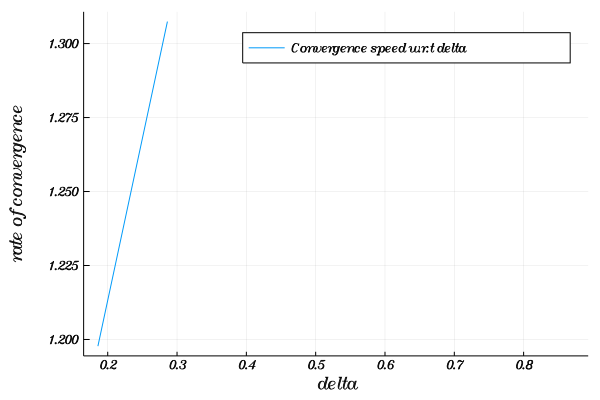

In [140]:
delt_l = rand(Float64,(5))
sort!(delt_l)

d11 = Dict(:b=>β,:d=>delt_l[1],:g=>g,:s=>s,:a=>α)
d22 = Dict(:b=>β,:d=>delt_l[2],:g=>g,:s=>s,:a=>α)
d33 = Dict(:b=>β,:d=>delt_l[3],:g=>g,:s=>s,:a=>α)
d44 = Dict(:b=>β,:d=>delt_l[4],:g=>g,:s=>s,:a=>α)
d55 = Dict(:b=>β,:d=>delt_l[5],:g=>g,:s=>s,:a=>α)

conv_delt = [convergence(k0,d11),convergence(k0,d22),convergence(k0,d33),convergence(k0,d44),convergence(k0,d55)]

plot(delt_l,conv_delt,xlabel="delta",ylabel="rate of convergence",label="Convergence speed w.r.t delta")

We observe that when alpha increases, we have a lower speed of convergence and when delta increases we have a higher speed of convergence

__Compute the steady-state directly using a Newton method and compare convergence speed.__

In [183]:
#We analytically compute the first and second derivatives of our function f

function first_d(k::Int64, p::Dict{Symbol,Float64})
    return p[:a]*p[:s]*A*(k^(p[:a]-1)) + (1-p[:g]-p[:d])
end

function second_d(k::Int64, p::Dict{Symbol,Float64})
    return p[:a]*(p[:a]-1)*p[:s]*A*(k^(p[:a]-2))
end

function newton_raphson(F::Function,p::Dict{Symbol,Float64},k = 2.0, iter = 1000.0, ϵ = 0.0001, η = 0.01)
    Δ = 1.0
    i = 0
    while i < iter && abs(Δ) > η
        k_next = k - (first_d(k,p)/second_d(k,p))
        Δ = k_next - k
        if abs(Δ) < η || first_d(k,p) < ϵ
            println(i)
            return k_next
        else
            k = k_next    
            i += 1
        end
    end
    #println("Number of max iterations attained")
end

newton_raphson (generic function with 10 methods)

In [184]:
newton_raphson(f)

Number of max iterations attained


__Suppose one tries to maximize steady-state consumption by choosing saving rate $s$. Which value would one choose?__

__(Bonus) Suppose an agent is given the intertemporal utility from the Ramsey–Cass–Koopmans model but chooses saving rate once for all. Which saving rate would one choose? Is it the same for all initial levels of capital?__



In [2]:
using Pkg
Pkg.add("Optim")


   Updating registry at `~/.juliapro/JuliaPro_v1.4.0-1/registries/JuliaPro`
######################################################################### 100.0%
  Resolving package versions...
  Installed libvorbis_jll ────────── v1.3.6+3
  Installed Ogg_jll ──────────────── v1.3.4+0
  Installed PDMats ───────────────── v0.9.12
  Installed PlotThemes ───────────── v2.0.0
  Installed Plots ────────────────── v1.2.2
  Installed Optim ────────────────── v0.21.0
  Installed Distributions ────────── v0.23.2
  Installed Rmath_jll ────────────── v0.2.2+0
  Installed FillArrays ───────────── v0.8.8
  Installed RecipesPipeline ──────── v0.1.6
  Installed StatsFuns ────────────── v0.9.4
  Installed Rmath ────────────────── v0.6.1
  Installed Opus_jll ─────────────── v1.3.1+1
  Installed ColorTypes ───────────── v0.10.3
  Installed PlotUtils ────────────── v1.0.2
  Installed OpenBLAS_jll ─────────── v0.3.9+4
  Installed PositiveFactorizations ─ v0.2.3
  Installed libass_jll ───────────── v0.14.0+1
  

   Building Plots → `~/.juliapro/JuliaPro_v1.4.0-1/packages/Plots/V8QVi/deps/build.log`


---

## Exercise: constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

__Use Optim.jl to minimize $f$ without constraint. Check you understand diagnostic information returned by the optimizer.__

Let's plot the function in order to see what it looks like.

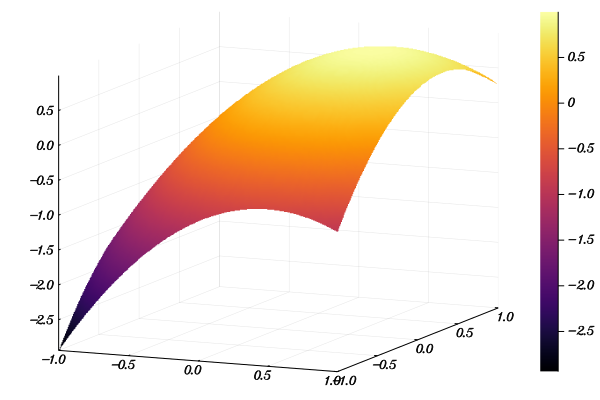

In [186]:
using Plots
x = range(-1,stop=1,length=100)
y = range(-1,stop=1,length=100)
f(x,y) = 1-(x-0.5)^2 - (y-0.3)^2
plot(x,y,f,st=:surface)

We can expect to not find a minimum for this function.

In [192]:
using Optim
f(x) = 1-(x[1]-0.5)^2 - (x[2]-0.3)^2
f1(x) = -1+(x[1]-0.5)^2 + (x[2]-0.3)^2 # f1 = -f
x0 = [0.0,0.0]
optimize(f1,x0)

 * Status: success

 * Candidate solution
    Minimizer: [5.00e-01, 3.00e-01]
    Minimum:   -1.000000e+00

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [0.00e+00, 0.00e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    34
    f(x) calls:    67


The algorithm proposes 1 as maximim and (0.5,0.3) as maximizer of this function when there is no constraint.
Let's try with the Newton algorithm (that we've seen from class), for that we need the gradient and hessian of the function

In [193]:
#gradient
function g!(G,x)
    G[1] = 2*(x[1]-0.5)
    G[2] = 2*(x[2]-0.3)
end

g! (generic function with 1 method)

In [194]:
#hessian
function h!(H,x)
    H[1,1] = 2
    H[1,2] = 0
    H[2,1] = 0
    H[2,2] = 2
end

h! (generic function with 1 method)

In [195]:
optimize(f1,g!,h!,x0)

 * Status: success

 * Candidate solution
    Minimizer: [5.00e-01, 3.00e-01]
    Minimum:   -1.000000e+00

 * Found with
    Algorithm:     Newton's Method
    Initial Point: [0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 5.00e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.40e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.40e-01 ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    4
    ∇f(x) calls:   4
    ∇²f(x) calls:  1


It yields the same solution as above

__Now, consider the constraint $x<0.3$ and maximize $f$ under this new constraint.__

In [196]:
using Optim
ϵ = 0.01

lower = [-Inf,-Inf]
upper = [0.3+ϵ, Inf]
inner_optimizer = GradientDescent()
results = optimize(f1,g!,lower,upper,x0,Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Minimizer: [3.10e-01, 3.00e-01]
    Minimum:   -9.639000e-01

 * Found with
    Algorithm:     Fminbox with Gradient Descent
    Initial Point: [0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.80e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    7
    f(x) calls:    1223
    ∇f(x) calls:   1223


We get 0.963 as maximum and the point (0.3,0.3) as maximizer 

__Reformulate the problem as a root finding with lagrangians. Write the complementarity conditions.__

The problem rewrites as: 
$$\begin{align}
\mathcal{L}(x,y,\lambda) &= f(x,y) - \lambda(x-0.3)\\
\mathcal{L}(x,y,\lambda) &= 1 - (x - 0.5)^{2} - (y-0.3)^2 - \lambda(x-0.3)
\end{align}$$

And the first order conditions are:

$$\begin{align}
    \frac{\mathcal{L}(x,y,\lambda)}{\delta x} &= -2(x-0.5)-\lambda &=0 \\
    \frac{\mathcal{L}(x,y,\lambda)}{\delta y} &= -2(y-0.3) &=0 \\
    \frac{\mathcal{L}(x,y,\lambda)}{\delta \lambda} &= x-0.3 &=0
\end{align}$$

and 
$$\begin{align}
\lambda(x-0.3) &= 0 \\
\lambda &\geq 0
\end{align}$$ are the complementarity conditions

__Solve using NLSolve.jl__

In [4]:
using Pkg
Pkg.add("NLsolve")

  Resolving package versions...
   Updating `~/Documents/Classes S6/ECO309/eco309-master_3/eco309-master/Project.toml`
 [no changes]
   Updating `~/Documents/Classes S6/ECO309/eco309-master_3/eco309-master/Manifest.toml`
 [no changes]


In [200]:
using NLsolve
function f!(F,x)
    F[1] = -2(x[1]-0.5)
    F[2] = -2(x[2]-0.3)
end

function j!(J,x)
    J[1,1] = -2
    J[1,2] = 0 
    J[2,1] = 0
    J[2,2] = -2
end
nlsolve(f!,j!,x0)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [0.5, 0.3]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

Nlsolve yields the solution (x,y) = (0.5,0.3)

---

## Consumption optimization

A consumer has preferences $U(c_1, c_2)$ over two consumption goods $c_1$ and $c_2$.

Given a budget $I$, consumer wants to maximize utility subject to the budget constraint $p_1 c_1 + p_2 c_2 \leq I$.

We choose a Stone-Geary specification where

$U(c_1, c_2)=\beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2)$

__Write the Karush-Kuhn-Tucker necessary conditions for the problem.__

The Lagrangian of the problem writes as:
$$\begin{equation}
    \mathcal{L}(c_1,c_2,\lambda) = \beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2) - \lambda(p_1 c_1 + p_2 c_2 -I)
\end{equation}$$

The KKT conditions for the problem are:
$$\begin{align}
       \frac{\mathcal{L}(c_1,c_2,\lambda)}{\delta c_1} = \frac{\beta_1}{c_1 - \gamma_1} - \lambda p_1 &=0 \hspace{5mm}(1) \\
       \frac{\mathcal{L}(c_1,c_2,\lambda)}{\delta c_2} = \frac{\beta_2}{c_2 - \gamma_2} - \lambda p_2 &=0 \hspace{5mm}(2) \\
       \lambda(p_1 c_1 + p_2 c_2 -I) &=0 \hspace{5mm}(3) \\
       \lambda &\geq 0 \hspace{5mm}(4)
\end{align}$$

__Verify the KKT conditions are sufficient for optimality.__

We know that the KKT necessary conditions are sufficient for optimality (maximization) if the fonction $U(c_1,c_2)$ is concave and if the budget constraint is a continuously differentiable convex function.

The budget constraint $p_1 c_1 + p_2 c_2 \leq I$ is continuously differentiable and convex (Easy to see that Hessian is the zero matrix). Now we want to prove that $U(c_1,c_2)$ is concave. For that we need to check that the Hessian of $U$ is negative semi-definite.

The hessian matrix writes as:
$$\begin{equation}
H_U = 
\begin{pmatrix}
\frac{-\beta_1}{(c_1-\gamma_1)^2} & 0 \\
0 & \frac{-\beta_2}{(c_2-\gamma_2)^2}
\end{pmatrix}
\end{equation}$$

It is negative semi-definite if $x^{T}H_{U}x \leq 0$ for $x \in \mathbb{R}^2$

Let $x^T =(x_1,x_2)$, $x^{T}H_{U}x = -\frac{\beta_1}{(c_1 - \gamma_1)^2}x_1^{2} -\frac{\beta_2}{(c_2 - \gamma_2)^2}x_2^{2}$. 
$x^{T}H_{U}x \leq 0$. Thus $U(c_1,c_2)$ is concave and the KKT conditions stated above are sufficient for optimality

__Derive analytically the demand functions, and the shadow price.__

With the condition above, we derive the following demand functions

Let $\alpha = \frac{\beta_1}{\beta_2}$

- For product 1: $c_1^{*} = \frac{I - p_{2}\gamma_{2} + \gamma_{1}p_{1}\alpha}{p_1 + p_{1}\alpha}$

- For product 2 : $c_2^{*} = \frac{p_2}{p_1}\frac{1}{\alpha}[\frac{I - \gamma_{2}p_{2} - \gamma_{1}p_{1}}{p_1 + p_1\alpha}] + \gamma_{2}$

And the shadow price corresponds to $\lambda^{*} = \frac{\beta_2(c_{1}^{*}-\gamma_{1}) - \beta_1(c_2^{*} - \gamma_2)}{(c_2^{*} - \gamma_{2})(c_{1}^{*}-\gamma_{1})(p_{2}-p_{1})}$

__Interpret this problem as a complementarity problem and solve it using NLSolve.__

This problem can be interpreted as a nonlinear complementarity problem since equations (3) and (4) are complementarity conditions. Now we solve it with NLSolve

In [34]:
I = 20
p1 = 5
p2 = 3
l = 1
β1 = 0.5
β2 = 0.5
α = β1/β2 
γ1 = 1
γ2 = -1

using NLsolve
function f!(F,x)
    F[1] = β1/(x[1]-γ1) -l*p1
    F[2] = β2/(x[2]-γ2) -l*p2
end

function j!(J,x)
    J[1,1] = -β1/((x[1]-γ1)^2)
    J[1,2] = 0 
    J[2,1] = 0
    J[2,2] = -β2/((x[2]-γ2)^2)
end
nlsolve(f!,j!,[0.0,0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [-1.5387185045456045e15, -0.8333333333333355]
 * Inf-norm of residuals: 5.000000
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 23
 * Jacobian Calls (df/dx): 17

__Produce some nice graphs with isoutility curves, the budget constraint and the optimal choice.__



In [3]:
I = 20
p1 = 5
p2 = 3

β1 = 0.5
β2 = 0.5
α = β1/β2 
γ1 = 1
γ2 = -1
optim_c1 = (I-p2*γ2 + p1*γ1*α)/(p1+p1*α)
optim_c2 = γ2+(p2/p1)*(1/α)*(I-p2*γ2-p1*γ1)/(p1+p1*α)
using Plots
plot(optim_c1,γ2+(p1/p2)*α*(optim_c1-γ1))

ErrorException: Cannot convert Float64 to series data for plotting